<a href="https://colab.research.google.com/github/MathRi-ATG/Pseudo-Spectral-Method/blob/main/Spectral_Methods_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acid Mediated Tumor Growth Model
## Gatenby and Gawlinski Model Solution Applying the Spectral Method
This notebook demonstrates a spectral collocation method (Chebyshev) to solve a 1D radially symmetric version of the **Gatenby-Gawlinski tumor invasion model**. The model describes interactions between:

- Normal cells $ N_n(r, t) $
- Tumor cells $ N_t(r, t) $
- Excess hydrogen ion concentration (acidity) $ C_h(r, t) $

---


## Mathmatical Model
$$
\frac{\partial N_n}{\partial t} = r_{n1} N_n \left( 1 - \frac{N_n}{K_n} \right) - r_{n2} C_h N_n,
$$

$$
\frac{\partial N_t}{\partial t} = r_{t1} N_t \left( 1 - \frac{N_t}{K_t} \right)
+ \frac{1}{r^2} \frac{\partial}{\partial r} \left[ r^2 D(N_n) \frac{\partial N_t}{\partial r} \right],
\quad D(N_n) = D_t \left( 1 - \frac{N_n}{K_n} \right),
$$

$$
\frac{\partial C_h}{\partial t} = r_{h1} N_t - r_{h2} C_h + D_h \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 \frac{\partial C_h}{\partial r} \right).
$$

## Model Parameters

The system is governed by the following biological parameters:

| Parameter | Value | Description | Units |
|-----------|-------|-------------|-------|
| $r_{n1}$  | $1.0 \times 10^{-6}$ | Normal cell growth rate | $s^{-1}$ |
| $r_{n2}$  | $1.0$                | Acid-induced death rate | $M^{-1}s^{-1}$ |
| $r_{t1}$  | $1.0 \times 10^{-6}$ | Tumor cell growth rate | $s^{-1}$ |
| $r_{h1}$  | $2.2 \times 10^{-17}$| H⁺ production rate | $M\cdot cm^3 \cdot cell^{-1}\cdot s^{-1}$ |
| $r_{h2}$  | $1.1 \times 10^{-4}$ | H⁺ decay rate | $s^{-1}$ |
| $K_n$     | $5.0 \times 10^7$    | Normal cell carrying capacity | $cells\cdot cm^{-3}$ |
| $K_t$     | $5.0 \times 10^7$    | Tumor cell carrying capacity | $cells\cdot cm^{-3}$ |
| $D_t$     | $2.0 \times 10^{-10}$| Tumor cell diffusivity | $cm^2\cdot s^{-1}$ |
| $D_h$     | $5.0 \times 10^{-6}$ | H⁺ ion diffusivity | $cm^2\cdot s^{-1}$ |

In [15]:
r_n1 = 1.0e-6    # Normal cell growth rate
r_n2 = 1.0       # Acid-induced death rate
r_t1 = 1.0e-6    # Tumor growth rate
r_h1 = 2.2e-17   # H+ production rate
r_h2 = 1.1e-4    # H+ decay rate
K_n = 5.0e7      # Normal cell capacity
K_t = 5.0e7      # Tumor cell capacity
D_t = 2.0e-10    # Tumor diffusivity
D_h = 5.0e-6     # H+ diffusivity

In [16]:
# @title Important Libraries Import
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [17]:
# @title Chebychev Grid
N = 100
k = np.arange(N+1)
R = 0.5
r = R * (1 - np.cos(np.pi * k / N)) / 2

### Chebyshev Spectral Differentiation Matrix

To compute derivatives spectrally, we use the Chebyshev–Gauss–Lobatto collocation method. The Chebyshev nodes on the interval \([-1, 1]\) are defined as:

$$
x_j = \cos\left(\frac{\pi j}{N}\right), \quad j = 0, 1, \dots, N
$$

These nodes cluster near the boundaries and allow accurate resolution of boundary layers.

The Chebyshev first-order differentiation matrix $$D \in \mathbb{R}^{(N+1) \times (N+1)}$$ is constructed as:

$$
D_{ij} =
\begin{cases}
\displaystyle \frac{c_i}{c_j} \cdot \frac{(-1)^{i+j}}{x_i - x_j}, & i \ne j \\\\
\displaystyle -\frac{x_j}{2(1 - x_j^2)}, & 1 \le j \le N-1,\ i = j \\\\
\displaystyle \frac{2N^2 + 1}{6}, & i = j = 0 \\\\
\displaystyle -\frac{2N^2 + 1}{6}, & i = j = N
\end{cases}
$$

where the weights \(c_j\) are given by:

$$
c_j =
\begin{cases}
2, & j = 0 \text{ or } j = N \\\\
1, & \text{otherwise}
\end{cases}
$$

To scale this matrix from the reference domain \([-1, 1]\) to the physical domain \([0, R]\), apply:

$$
D_r = \frac{2}{R} D
$$

This matrix approximates the spatial derivative with respect to $r \in [0, R]$, suitable for use in solving PDEs such as reaction-diffusion systems with spherical symmetry.


In [18]:
def cheb_diff_matrix(N, R):
    x = np.cos(np.pi * np.arange(N+1) / N)  # [-1, 1]
    c = np.ones(N+1)
    c[0] = c[-1] = 2
    D = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(N+1):
            if i != j:
                D[i, j] = (-1)**(i + j) * c[i] / (c[j] * (x[i] - x[j]))
            elif i == j == 0:
                D[i, j] = (2 * N**2 + 1) / 6
            elif i == j == N:
                D[i, j] = -(2 * N**2 + 1) / 6
            else:
                D[i, j] = -x[i] / (2 * (1 - x[i]**2))
    return (2 / R) * D

### Initial Conditions and Neumann Boundary Conditions

To impose **Neumann boundary conditions** (zero flux at boundaries), we modify the second derivative matrix:

- Instead of using the standard Chebyshev second derivative matrix $D^{(2)}$, we replace its first and last rows with the first derivative matrix rows at the boundaries:
  $$
  D^{(2)}_{\text{bc}}[0, :] = D^{(1)}[0, :], \quad D^{(2)}_{\text{bc}}[-1, :] = D^{(1)}[-1, :]
  $$
  This enforces $\frac{\partial u}{\partial r} = 0$ at $r = 0$ and $r = R$, consistent with symmetry and no-flux conditions.

---

We define smooth initial conditions using a **hyperbolic tangent profile** to smoothly transition between different densities across a radial threshold:

- For normal cells $N_n(r, 0)$:
  $$
  N_n(r, 0) = \frac{5 \times 10^7}{2}(1 - \tanh(20(r - 0.1))) + \frac{10^8}{2}(1 + \tanh(20(r - 0.1)))
  $$

- For tumor cells $N_t(r, 0)$:
  $$
  N_t(r, 0) = \frac{10^5}{2}(1 - \tanh(20(r - 0.1))) + \frac{10^3}{2}(1 + \tanh(20(r - 0.1)))
  $$

- For acid concentration $C_h(r, 0)$:
  $$
  C_h(r, 0) = \frac{10^{-9}}{2}(1 - \tanh(20(r - 0.1)))
  $$

These functions represent an initially healthy tissue with a localized tumor and acid distribution centered around $r = 0.1$ cm. The smoothness of the $\tanh$ function avoids numerical instability and helps spectral methods converge rapidly.


In [19]:
D1 = cheb_diff_matrix(N, R)
D2 = D1 @ D1

# Neumann BCs
D2_bc = D2.copy()
D2_bc[0, :] = D1[0, :]
D2_bc[-1, :] = D1[-1, :]

# === Initial Conditions ===
tanh_r = np.tanh(20 * (r - 0.1))  # softened transition
N_n0 = 5.0e7 * (1 - tanh_r) / 2 + 1.0e8 * (1 + tanh_r) / 2
N_t0 = 1.0e5 * (1 - tanh_r) / 2 + 1.0e3 * (1 + tanh_r) / 2
C_h0 = 1.0e-9 * (1 - tanh_r) / 2

y0 = np.concatenate([N_n0, N_t0, C_h0])

In [20]:
def tumor_rhs(t, y):
    N_n = y[:N+1]
    N_t = y[N+1:2*(N+1)]
    C_h = y[2*(N+1):]

    # Clip to prevent overflow/NaNs
    N_n = np.clip(N_n, 0, 1e9)
    N_t = np.clip(N_t, 0, 1e9)
    C_h = np.clip(C_h, 0, 1e-3)

    # Reactions
    dNn = r_n1 * N_n * (1 - N_n / K_n) - r_n2 * C_h * N_n
    dNt = r_t1 * N_t * (1 - N_t / K_t)
    dCh = r_h1 * N_t - r_h2 * C_h

    # Diffusion
    dNt += D_t * (D2_bc @ N_t)

    laplacian = D2_bc @ C_h + (2 / r) * (- D1 @ C_h)
    laplacian[0] = 3 * (D2 @ C_h)[0]
    dCh += D_h * laplacian

    return np.concatenate([dNn, dNt, dCh])

### Time Integration Setup

We integrate the tumor model ODE system using SciPy’s `solve_ivp` function with the **BDF** (Backward Differentiation Formula) method, which is particularly well-suited for stiff systems such as coupled reaction-diffusion equations.

---

**Time Span and Evaluation Points**

We define the simulation time range and the specific time points at which we want to record the solution:

- The time span is:
  $$
  t_{\text{span}} = (0, 5.00256 \times 10^6) \quad \text{seconds}
  $$
  This corresponds to roughly:
  $$
  \frac{5.00256 \times 10^6}{86400} \approx 57.9 \text{ days}
  $$

- Evaluation times:
  $$
  t_{\text{eval}} = \text{linspace}(0, 5.00256 \times 10^6, 6)
  $$
  This returns 6 equally spaced time points (including the start and end) for sampling the solution.



In [21]:
t_span = (0, 5.00256e6)
t_eval = np.linspace(*t_span, 6)

sol = solve_ivp(
    tumor_rhs, t_span, y0, t_eval=t_eval,
    method='BDF', rtol=1e-6, atol=1e-9, max_step=1e5
)


/tmp/ipython-input-2589537282.py:19: RuntimeWarning: divide by zero encountered in divide
  laplacian = D2_bc @ C_h + (2 / r) * (- D1 @ C_h)


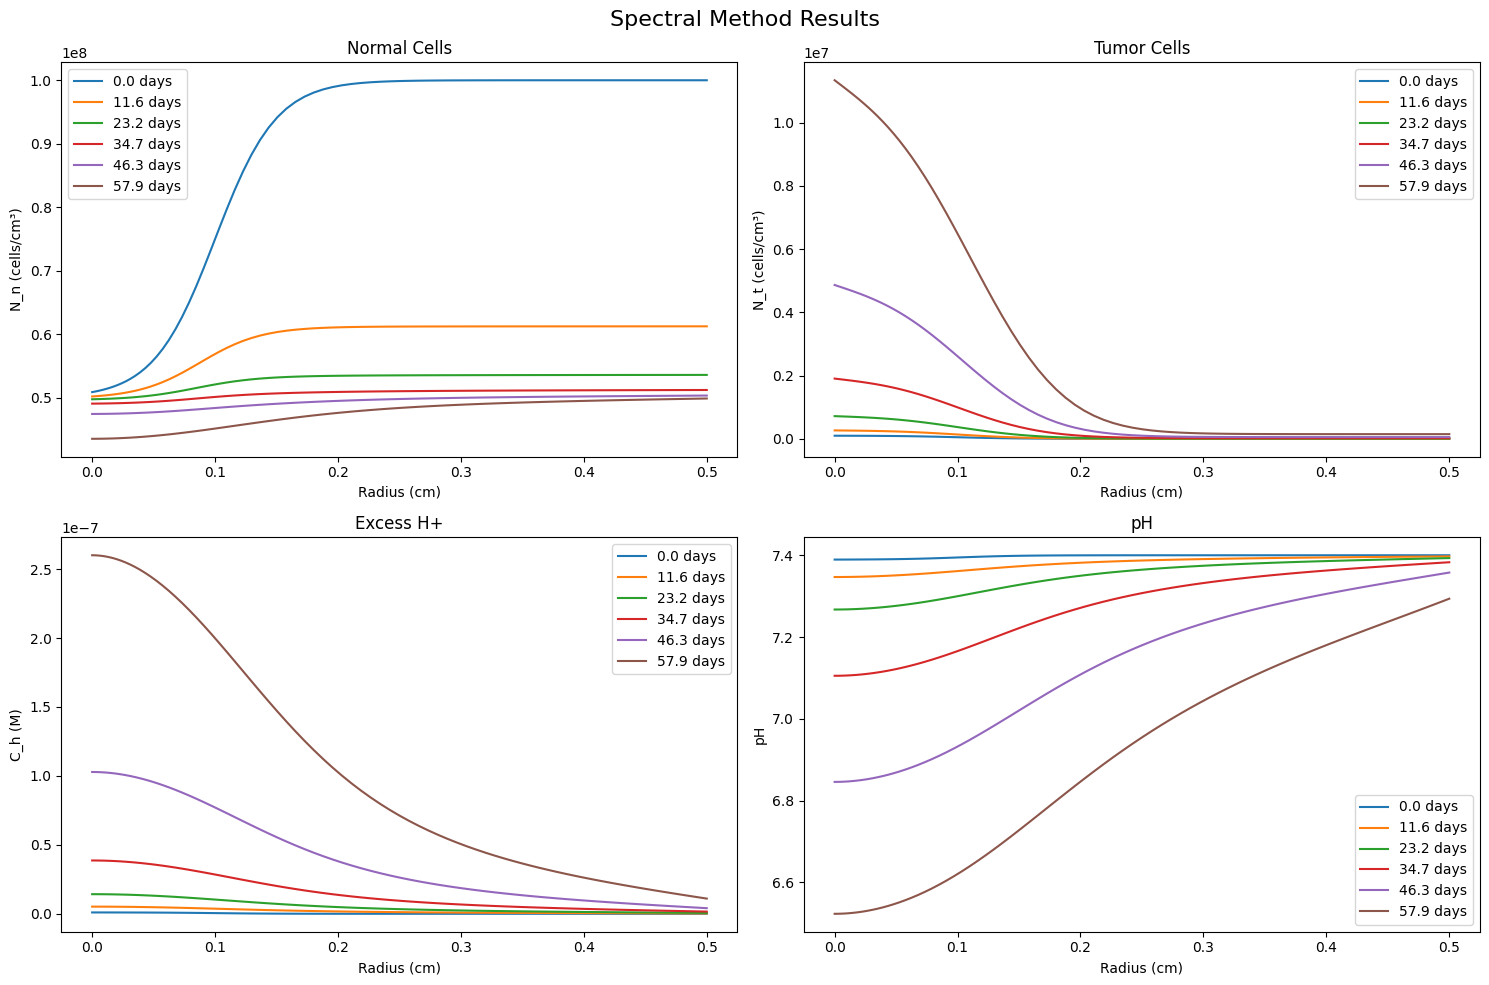

In [22]:
# @title Solution Plotting
N_n_plot = sol.y[:N+1]
N_t_plot = sol.y[N+1:2*(N+1)]
C_h_plot = sol.y[2*(N+1):]
pH_plot = -np.log10(np.clip(C_h_plot+10**(-7.4), 1e-20, None))

# === 2D Plots ===
plt.figure(figsize=(15, 10))
plt.suptitle('Spectral Method Results', fontsize=16)

def plot_field(subplot, data, title, ylabel):
    plt.subplot(2, 2, subplot)
    for i, t in enumerate(sol.t):
        plt.plot(r, data[:, i], label=f'{t/(24*3600):.1f} days')
    plt.title(title)
    plt.xlabel('Radius (cm)')
    plt.ylabel(ylabel)
    plt.legend()

plot_field(1, N_n_plot, 'Normal Cells', 'N_n (cells/cm³)')
plot_field(2, N_t_plot, 'Tumor Cells', 'N_t (cells/cm³)')
plot_field(3, C_h_plot, 'Excess H+', 'C_h (M)')
plot_field(4, pH_plot, 'pH', 'pH')

plt.tight_layout()
plt.show()

## Modeling and Numerical Choices Justification

### 1. Spatial Discretization: Chebyshev Spectral Collocation

The Chebyshev collocation method is preferred over finite differences due to its high accuracy for problems with smooth solutions. In this tumor invasion model, the fields (normal cells, tumor cells, and acid concentration) evolve smoothly in space, making them well-suited for spectral methods.

The method uses Chebyshev–Gauss–Lobatto points to achieve exponential convergence. Compared to finite difference methods, it can achieve much higher accuracy with fewer spatial points. The differentiation matrices are computed once and used to approximate spatial derivatives efficiently.

We map the physical radial domain \( [0, R] \) to the standard Chebyshev domain \( [-1, 1] \) using a linear transformation. To maintain spherical symmetry, we express the diffusion term as:

$$
\frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 D(r) \frac{\partial u}{\partial r} \right)
$$

We approximate this term by applying the Chebyshev differentiation matrices in collocation space and transforming the result appropriately using the chain rule.

### 2. Boundary Conditions: Neumann (Zero Flux)

We enforce homogeneous Neumann boundary conditions (zero flux) at \( r = 0 \) and \( r = R \). At \( r = 0 \), this condition also ensures symmetry for the radially symmetric problem.

This is done by replacing the first and last rows of the second derivative matrix \( D^{(2)} \) with the first derivative matrix \( D^{(1)} \), then approximating the zero-derivative condition:

$$
\left. \frac{\partial u}{\partial r} \right|_{r=0} = 0, \quad \left. \frac{\partial u}{\partial r} \right|_{r=R} = 0
$$

### 3. Initial Conditions

The initial profiles for $ N_n $, $ N_t $, and $ C_h $ are set using smooth hyperbolic tangent functions to mimic biological interfaces. These functions allow a soft transition between tumor and healthy tissue regions:

- Normal cells:

$$
N_n(r) = \frac{5.0 \times 10^7 (1 - \tanh(20(r - 0.1)))}{2} + \frac{1.0 \times 10^8 (1 + \tanh(20(r - 0.1)))}{2}
$$

- Tumor cells:

$$
N_t(r) = \frac{1.0 \times 10^5 (1 - \tanh(20(r - 0.1)))}{2} + \frac{1.0 \times 10^3 (1 + \tanh(20(r - 0.1)))}{2}
$$

- Acid:

$$
C_h(r) = \frac{1.0 \times 10^{-9} (1 - \tanh(20(r - 0.1)))}{2}
$$

These profiles are biologically motivated and consistent with modeling literature. The tanh-based transitions ensure differentiability and numerical stability.


| **Component**                    | **Complexity**             | **Explanation**                                                                 |
|----------------------------------|-----------------------------|----------------------------------------------------------------------------------|
| **Spatial Derivatives (Matrices)** |  $O(N^2)$      | Dense Chebyshev differentiation matrices of size $(N+1) \times (N+1) $          |
| **Nonlinear Term Evaluation**     | $O(N)$        | Evaluated pointwise on the collocation grid                                     |
| **Time Integration (BDF)**        | $(kN^3)$     | Implicit method requiring Jacobian evaluations and linear solves per step       |
| **Total Computational Cost**      | $(kN^3)$     | Dominated by BDF time-stepping of coupled nonlinear PDEs                        |
| **Memory (Space) Usage**          | $(N^2)$      | Due to storage of spectral differentiation matrices and intermediate arrays     |

> - \(N\): Number of spatial collocation points  
> - \(k\): Number of time steps (depends on stiffness and solver tolerance)  
> - The cost is dominated by the BDF method solving large nonlinear systems at each time step.

### However
we faced a problem when outputing the results. The values of $C_h$ and the $Ph$ seams incorrect in comparison to the Method of lines applied in the given Textbook. We don't seem to understand what the issue is as we applied everything we known and handeld every error and issue we faced.

In [ ]:
Nt_all = sol.y[N+1:2*(N+1), :]
def radial_to_2d(u_r, r, size=128):
    R_max = r[-1]
    x = np.linspace(-R_max, R_max, size)
    y = np.linspace(-R_max, R_max, size)
    X, Y = np.meshgrid(x, y)
    R_grid = np.sqrt(X**2 + Y**2)
    return np.interp(R_grid, r, u_r, left=0, right=0)

for t_idx in range(Nt_all.shape[1]):
    u_r = Nt_all[:, t_idx]
    img = radial_to_2d(u_r, r)
    plt.imsave(f"tumor_{t_idx:03d}.png", img, cmap='gray')
np.save(f"tumor_array_{t_idx:03d}.npy", img)
import time

for t_idx in range(Nt_all.shape[1]):
    u_r = Nt_all[:, t_idx]
    img = radial_to_2d(u_r, r)

    plt.imshow(img, cmap='gray')
    plt.title(f"Tumor at time step {t_idx}")
    plt.axis('off')
    plt.pause(0.1)
    plt.clf()